![](images/pumping_new.jpg)

# Title of the Analysis

**Authors:** Victor Chen, Aaron Cherry 

## Overview

With this analysis, we aim to predict the condition of waterwells in Tanzania based on data retreived from the Taarifa waterpoints dashboard. The dashboard aggregates information collected from the Tanzania Ministry of Water.

## Business Problem

A major challange of the Tanzanian Ministry of Water is determining when, where and how often a water well in Tanzania would need repairs. Implementation of models to predict the condition of a water well would greatly enhance maintenance operations, provide crucial updates associated with the conditions of the water wells and ensure that clean water sources can be provided to the communities in Tanzania. Through this analysis, we aim to provide prediction models based on the information collected to determine water well conditions to aid the Tanzanian Ministry of Water.

## Data Understanding

The data used for this analysis is taken from the Taarifa waterpoints dashboard that functions to aggregate weter well data collected from the Tanzania Ministry of Water. A link to the data and explanation of the features found in the data can be found [here](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/23/). A link to the Taarifa waterpoints dashboard website can be found [here](https://taarifa.org/). The link to the website for the Tanzania Ministry of Water can be found [here](https://www.maji.go.tz/).

The following table is a description of the features in the data along with descriptions of the features.


|**Feature**|**Description**|
|:----------|:------------|
|```amount_tsh``` | Total static head (amount water available to waterpoint)|
|```date_recorded``` | The date the row was entered|
|```funder``` | Who funded the well|
|```gps_height``` | Altitude of the well|
|```installer``` | Organization that installed the well|
|```longitude``` | GPS coordinate|
|```latitude``` | GPS coordinate|
|```wpt_name``` | Name of the waterpoint if there is one|
|```num_private``` | Unknown|
|```basin``` | Geographic water basin|
|```subvillage``` | Geographic location|
|```region``` | Geographic location|
|```region_code``` | Geographic location (coded)|
|```district_code``` | Geographic location (coded)|
|```lga``` | Geographic location|
|```ward``` | Geographic location|
|```population``` | Population around the well|
|```public_meeting``` | True/False|
|```recorded_by``` | Group entering this row of data|
|```scheme_management``` | Who operates the waterpoint|
|```scheme_name``` | Who operates the waterpoint|
|```permit``` | If the waterpoint is permitted|
|```construction_year``` | Year the waterpoint was constructed|
|```extraction_type``` | The kind of extraction the waterpoint uses|
|```extraction_type_group``` | The kind of extraction the waterpoint uses|
|```extraction_type_class``` | The kind of extraction the waterpoint uses|
|```management``` | How the waterpoint is managed|
|```management_group``` | How the waterpoint is managed|
|```payment``` | What the water costs|
|```payment_type``` | What the water costs|
|```water_quality``` | The quality of the water|
|```quality_group``` | The quality of the water|
|```quantity``` | The quantity of water|
|```quantity_group``` | The quantity of water|
|```source``` | The source of the water|
|```source_type``` | The source of the water|
|```source_class``` | The source of the water|
|```waterpoint_type``` | The kind of waterpoint|
|```waterpoint_type_group``` | The kind of waterpoint|

The target class in the data set is ```status_group``` and consists of three classes. The classes and their descriptions can be fouind in the table below:

|Label|Description|
|:-----|:------|
|```functional``` | the waterpoint is operational and there are no repairs needed|
|```functional needs repair``` | the waterpoint is operational, but needs repairs|
|```non functional``` | the waterpoint is not operational|

### Importing Packages and Loading the Datasets

In [115]:
#Import standard packages for data engineering and visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import date, datetime

#import packages to support geo visuals
import folium
from folium.plugins import HeatMap
import json

#Import packages to perform linear regression modeling and preprocessing tools
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.formula.api import ols

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.feature_selection import RFE
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, plot_roc_curve, classification_report, plot_confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV

from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
# import imb functions for oversampling under-represented classes
from imblearn.pipeline import Pipeline as ImbPipe
from imblearn.over_sampling import SMOTE


from sklearn.ensemble import BaggingClassifier, RandomForestClassifier,\
ExtraTreesClassifier, VotingClassifier
#Import local functions from src/
import sys
sys.path.insert(0, '../../src/')
from eda import EdaPlots


#Ignore warnings in cells
import warnings
warnings.filterwarnings('ignore')

# Display all of the columns when looking at DataFrame
pd.set_option('display.max_columns', None)

# Set plot themes
mpl.style.use('fivethirtyeight')

In [116]:
# Import all data sets
X = pd.read_csv('../../data/water_well_training_values.csv')
y = pd.read_csv('../../data/water_well_training_labels.csv')
test = pd.read_csv('../../data/water_well_test.csv')
df = pd.merge(y,X)

## Data Preparation

- There are some features that have missing data. The first order of business will be to fill or drop these NaN values.
- There are no duplicate data points in the dataset
- There are some features that have data types that don't match with the feature description. These will be converted to the appropriate data type.
- There are some features that will have no significance in determining the classification.

In [93]:
# Confirm the columns with missing values
df.isna().sum()

id                           0
status_group                 0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_qu

### Dealing with missing values 
- The ```funder``` column gives the funding organization for the construction of the well. It is assumed that the well points that do not have an explicit funding source were not funded by a major organization and will be labeled ```other```.
- The ```subvillage``` feature gives the sub community in which the water well was installed. It is assumed that the water points with no explicit subvillage were installed outside of more populated areas and will be filled with ```other```.
- The ```installer``` feature lists the organization responsible for constructing the water well. Like the 'funder' column, it is assumed that the water points with no explicit installer were not constructed by a major organization and will be labelled as ```other```.
- The ```scheme_management``` feature labels the organization responsible for the operation of the water point. It is assumed that the water points with no explicit operation management are not managed by a major company and will be filled with ```other```.
- The ```public_meeting``` feature describes whether or not the water point was installed in a public meeting area. It is assumed that the water points with no explicit label are water points not installed in public areas and will be filled with ```other```.
- The ```scheme_name``` feature gives the name of the company responsible for the operation of the water point. One of the classes in the column is ```None``` and it is assumed that the water points with no explicit operation name are also ```other```.
- The ```permit``` features describes whether a permit has been issued for the water point. It is assumed that the water points with no explicit label are not permitted as the permitted water well are more likely to be represented in the dataset and so the values are replaced with ```other```.

### Converting Data Types

- date_recorded: object to datetime
- convert boolean types to string in order to apply a simple imputer

### Dropping Unnecessary Columns

- The ID column will not be used on the EDA or the models so we can just drop it.

# Feature Engineering

- The relative age of the water point at the time of the recording could possibly be a crucial factor in determining the water points function. Since the construction year has many 0's they will be binned by 5 years, converted to a categorical type and the construction years with ```0``` will be replaced with ```missing```. There are some data points where the construction year is after the date of the recording which doesn't make much sense. We assume that these were entered incorrectly and will be treated as ```missing```. We can now drop the ```date_recorded``` and ```construction_year``` columns.

- Some of the categorical variables have too many classes to effectively One Hot Encode and so the top 20 classes of the feature will be kept while the rest will be replaced with 'other'

In [118]:
# Set a new data set for the EDA and clean the data
eda = EdaPlots()
eda.init(df)
eda.clean()
data_eda = eda.df_

In [111]:
# convert the date_recorded column to date_time type
df['date_recorded'] = pd.to_datetime(df['date_recorded'])
test['date_recorded'] = pd.to_datetime(df['date_recorded'])


In [112]:
df['permit'] = df['permit'].astype(str)
df['public_meeting'] = df['public_meeting'].astype(str)

test['permit'] = test['permit'].astype(str)
test['public_meeting'] = test['public_meeting'].astype(str)

We will not be using the ID column in exploratory analysis or modeling.

### Dealing with outliers

The longitude, latitude, gps_height, amount_tsh, population, and the construction_year all show data points where the value is ```0```. These data points need to be addressed so as to ensure the model is being trained and validated on correct data.

#### - Latitude/Longitude/GPSheight
- As location might be a crucial feature in determining the label of the water point, these values should be cleaned. We decided that, since the overall data that presents with bad geographic information makes up 3% of the entire data set, those data points can be dropped without significant losses.

#### - Population
- The population surrounding the water point can give an idea of how much usage the waterpoint recieves. This could be a crucial feature in predicting the label for the water point and should be fixed. The 0's will be replaced with the mean of the column.

# Exploratory Data Analysis

### Bar Charts of the Categorical Features Separated by label

In [88]:
# grabbing the categorical data from the table for each label
functional_cats = df[(df['status_group'] == 'functional') & (df['water_quality'] != 'other')].select_dtypes('object')
not_functional_cats = df[(df['status_group'] == 'non functional') & (df['water_quality'] != 'other')].select_dtypes('object')
functional_needs_repair_cats = df[(df['status_group'] == 'functional needs repair') & (df['water_quality'] != 'other')].select_dtypes('object')

#### Effect of Water Quality on the Function

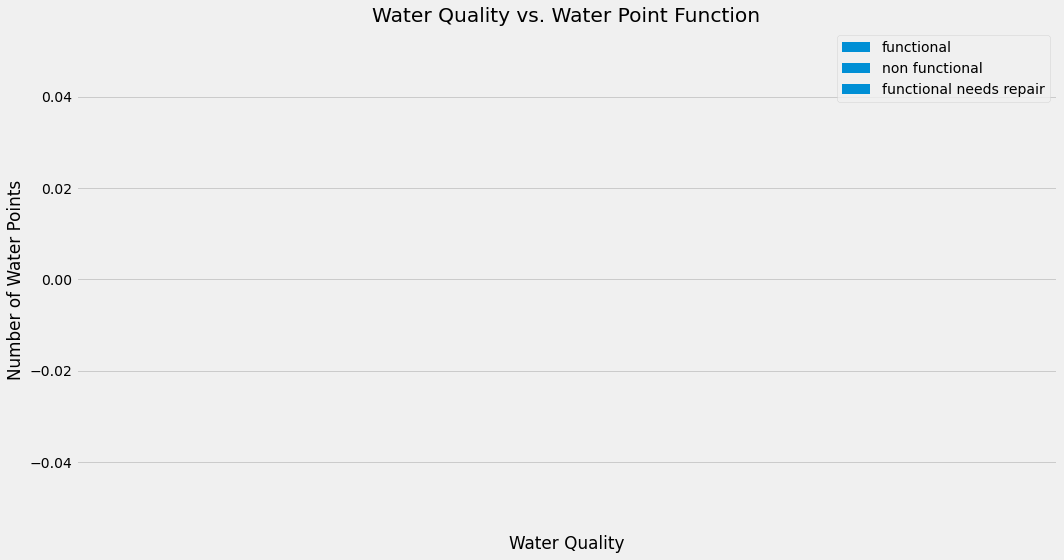

In [90]:
fig,ax = plt.subplots(figsize=(15,8)) 
width = 0.3
n = len(functional_cats.groupby('water_quality').count()['extraction_type'].index)
r = np.arange(n)

x_func = functional_cats.groupby('water_quality').count()['extraction_type'].index
y_func = functional_cats.groupby('water_quality').count()['extraction_type'].values
x_func_rep = functional_needs_repair_cats.groupby('water_quality').count()['extraction_type'].index
y_func_rep = functional_needs_repair_cats.groupby('water_quality').count()['extraction_type'].values
x_not_func = not_functional_cats.groupby('water_quality').count()['extraction_type'].index
y_not_func = not_functional_cats.groupby('water_quality').count()['extraction_type'].values

ax.bar(r,y_func,width=width,align='edge')
ax.bar(r-width,y_func_rep,width=width,align='edge')
ax.bar(r+width,y_not_func,width=width,align='edge')
plt.xticks(r + width/2,list(functional_cats.groupby('water_quality').count()['extraction_type'].index))
ax.set_title('Water Quality vs. Water Point Function')
ax.set_xlabel('Water Quality')
ax.set_ylabel('Number of Water Points')
ax.legend(['functional','non functional','functional needs repair'])
plt.tight_layout()

fig.savefig('../../images/water_quality.png');

There seems to be some kind of relationship btw the function of the water point and the water wuality as the ```soft``` quality has a much larger ratio of functional and non functional water points than ```salty```.

#### Extraction Type

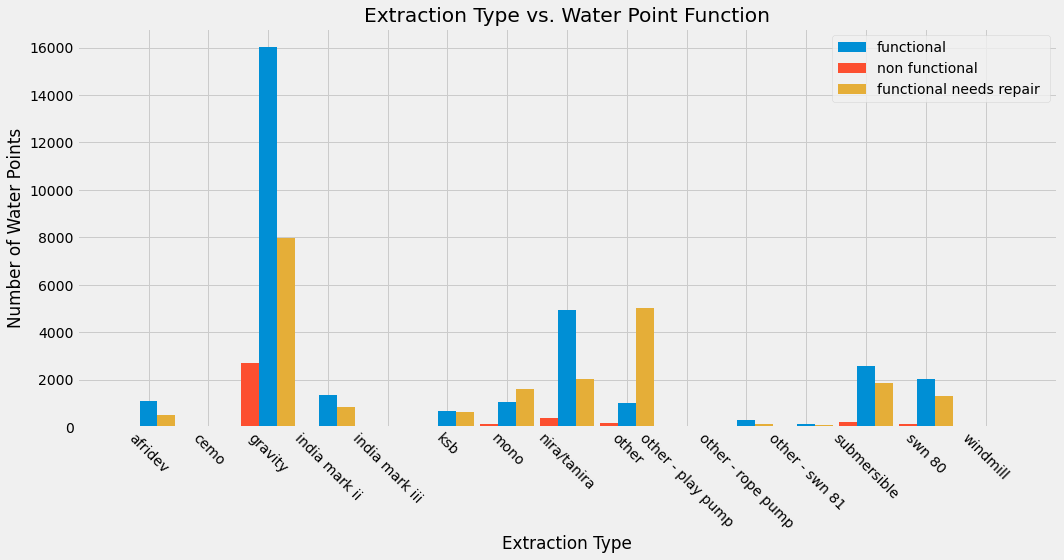

In [44]:
fig,ax = plt.subplots(figsize=(15,8)) 
width = 0.3
n = len(functional_cats.groupby('extraction_type').count()['funder'].index)
r = np.arange(n)

x_func = functional_cats.groupby('extraction_type').count()['funder'].index
y_func = functional_cats.groupby('extraction_type').count()['funder'].values
x_func_rep = functional_needs_repair_cats.groupby('extraction_type').count()['funder'].index
y_func_rep = functional_needs_repair_cats.groupby('extraction_type').count()['funder'].values
x_not_func = not_functional_cats.groupby('extraction_type').count()['funder'].index
y_not_func = not_functional_cats.groupby('extraction_type').count()['funder'].values

ax.bar(r,y_func,width=width,align='edge')
ax.bar(r-width,y_func_rep,width=width,align='edge')
ax.bar(r+width,y_not_func,width=width,align='edge')
plt.xticks(r + width/2,list(functional_cats.groupby('extraction_type').count()['funder'].index),rotation=-45)
ax.set_title('Extraction Type vs. Water Point Function')
ax.set_xlabel('Extraction Type')
ax.set_ylabel('Number of Water Points')
ax.legend(['functional','non functional','functional needs repair '])
plt.tight_layout()

fig.savefig('images/extraction_type.png');

There doesn't seem to be much of a correlation of Extraction Type with the function of the water point as most extraction types seem to have about the same ration of functional and non-functional water points. It should be ssaid here that the majority of the water points operate using the ```gravity``` extraction type.


#### Water Quantity

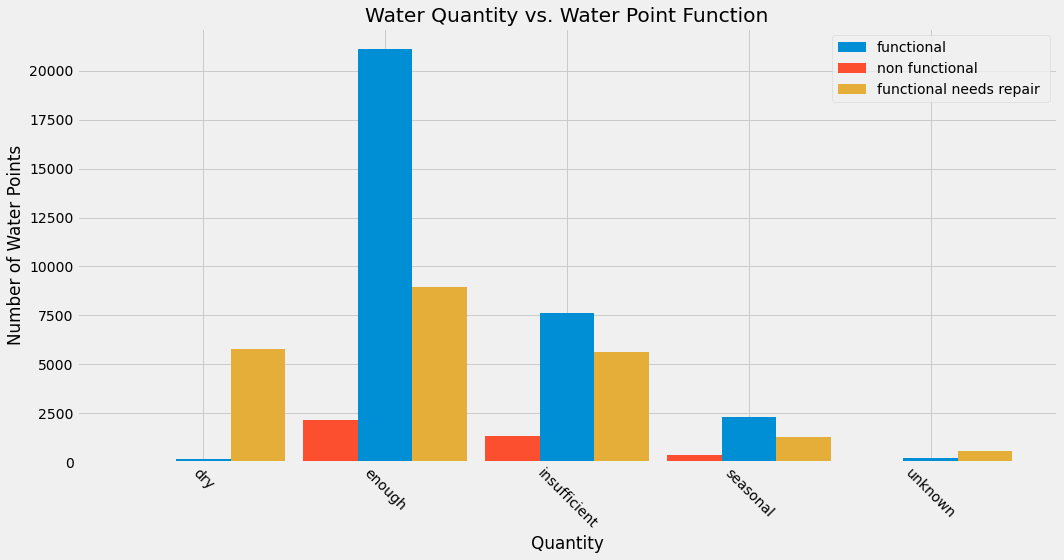

In [45]:
fig,ax = plt.subplots(figsize=(15,8)) 
width = 0.3
n = len(functional_cats.groupby('quantity').count()['funder'].index)
r = np.arange(n)

x_func = functional_cats.groupby('quantity').count()['funder'].index
y_func = functional_cats.groupby('quantity').count()['funder'].values
x_func_rep = functional_needs_repair_cats.groupby('quantity').count()['funder'].index
y_func_rep = functional_needs_repair_cats.groupby('quantity').count()['funder'].values
x_not_func = not_functional_cats.groupby('quantity').count()['funder'].index
y_not_func = not_functional_cats.groupby('quantity').count()['funder'].values

ax.bar(r,y_func,width=width,align='edge')
ax.bar(r-width,y_func_rep,width=width,align='edge')
ax.bar(r+width,y_not_func,width=width,align='edge')
plt.xticks(r + width/2,list(functional_cats.groupby('quantity').count()['funder'].index),rotation=-45)
ax.set_title('Water Quantity vs. Water Point Function')
ax.set_xlabel('Quantity')
ax.set_ylabel('Number of Water Points')
ax.legend(['functional','non functional','functional needs repair '])
plt.tight_layout()

fig.savefig('images/water_quantity.png');

There does seem to be some correlation btw the quantity of the water and the fonction of the water point. This is shown by the larger ratio of functioning water points to non functioning water points when the point is providing ```enough``` water.

#### Water Point Type

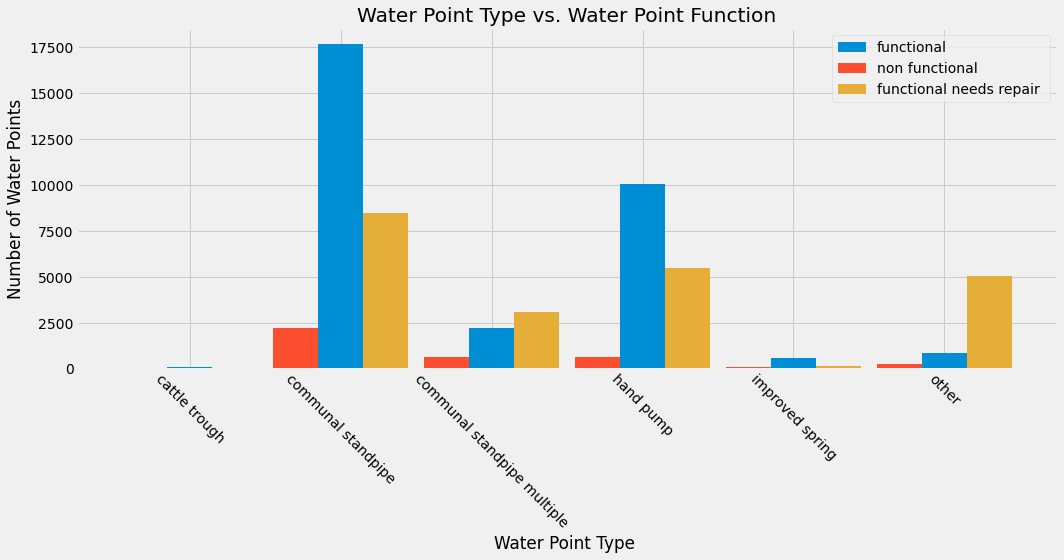

In [46]:
fig,ax = plt.subplots(figsize=(15,8)) 
width = 0.3
n = len(functional_cats.groupby('waterpoint_type').count()['funder'].index)
r = np.arange(n)

x_func = functional_cats.groupby('waterpoint_type').count()['funder'].index
y_func = functional_cats.groupby('waterpoint_type').count()['funder'].values
x_func_rep = functional_needs_repair_cats.groupby('waterpoint_type').count()['funder'].index
y_func_rep = functional_needs_repair_cats.groupby('waterpoint_type').count()['funder'].values
x_not_func = not_functional_cats.groupby('waterpoint_type').count()['funder'].index
y_not_func = not_functional_cats.groupby('waterpoint_type').count()['funder'].values

ax.bar(r,y_func,width=width,align='edge')
ax.bar(r-width,y_func_rep,width=width,align='edge')
ax.bar(r+width,y_not_func,width=width,align='edge')
plt.xticks(r + width/2,list(functional_cats.groupby('waterpoint_type').count()['funder'].index),rotation=-45)
ax.set_title('Water Point Type vs. Water Point Function')
ax.set_xlabel('Water Point Type ')
ax.set_ylabel('Number of Water Points')
ax.legend(['functional','non functional','functional needs repair '])
plt.tight_layout()

fig.savefig('images/wp_type.png');

There does seem to be some correlation btw the water point type and the function as the ratio of functional to non functional for ```standpipe``` is much larger than the ratio for ```hand pump```. As the standpipe configuration might be less complex, there could be less failure modes for the ```standpipe``` configuration.

#### Geographic Location

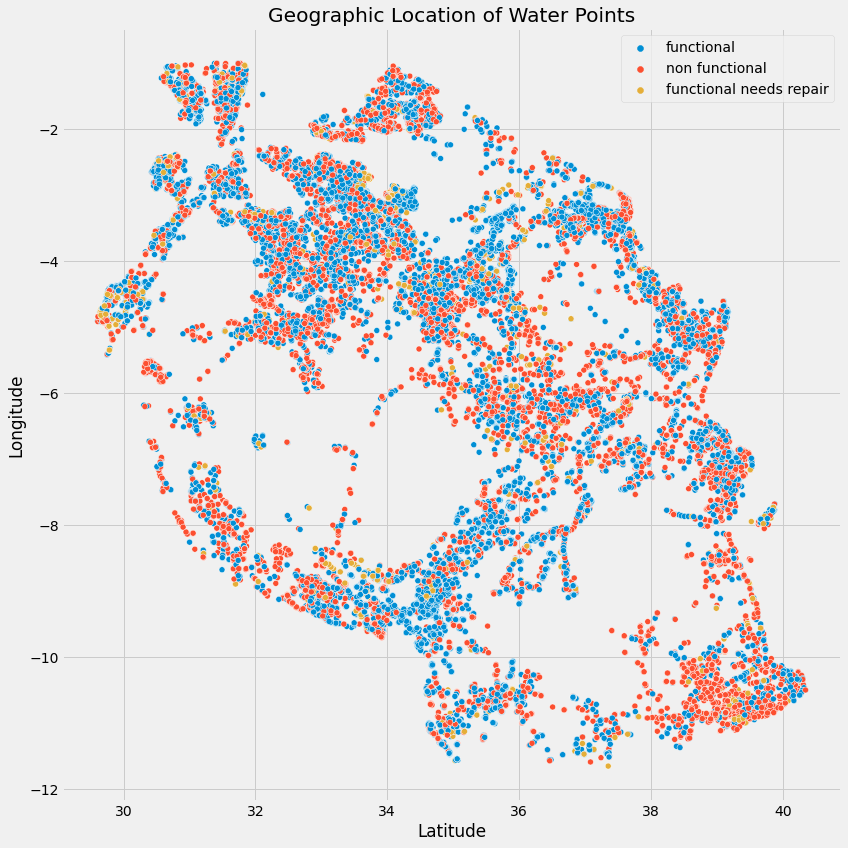

In [47]:
# Create scatter
fig1, ax = plt.subplots(figsize = (12,12))

x1 = df['longitude']
y1 = df['latitude']

#Build scatterplot
scatter = sns.scatterplot(x1,y1, hue = df['status_group'])
ax.set_xlabel("Latitude")
ax.set_ylabel("Longitude")
ax.set_title('Geographic Location of Water Points')
plt.ticklabel_format(style = 'plain', axis = 'y')
plt.tight_layout()
plt.legend(loc='upper right')
ax.patch.set_alpha(0)
#Save fig
fig1.savefig('images/well_function_location.png');

There does seem to be some regions that have a higher number of non-functional water points like the regions in the South West of the country and aound the capital.

# Modeling

#### Setting up the data for modeling
- Convert labels to ```int``` for use in some models
- splitting the data into target and feature sets
- train test splitting the data for testing
- initializing the column transformer to One Hot Encode the categoricala data and Standard Scale the continuous data
- split the training data into categorical data and continuous data to apply respective preprossessing

All models incorporate One Hot Encoding teh categorical data dropping the first column, Standard Scaling for all of the continuous variables, and SMOTE with the ```sampling_strategy``` set to 'minority' to properly oversample the minority class of ```functional needs repair```

In [130]:
# Convert the labels from str to integer type to match the assumptions of the base models
stat_map = {'functional':2,'functional needs repair':1,'non functional':0}
df['status_group'] = df['status_group'].map(stat_map)

In [131]:
# separate features and target
X = df.drop('status_group',axis=1)
y = df['status_group']

In [132]:
#train test split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.25,random_state=42)

In [133]:
# split the features into categorical and continuous data types for preprossessing
X_train_cat = X_train.select_dtypes('object')
X_test_cat = X_test.select_dtypes('object')

X_train_con = X_train.select_dtypes('float64')
X_test_con = X_test.select_dtypes('float64')

In [141]:
def age_bin(X):
    X['age_at_recording'] = pd.DatetimeIndex(X['date_recorded']).year - X['construction_year']
    X.loc[X['age_at_recording'] < 0,'age_at_recording'] = 0
    a = list(range(1,60,5))
    cut_bins = [-1]
    cut_bins.extend(a)
    cut_labels = ['missing','0-5','6-10','11-15','16-20','21-25','26-30','31-35','36-40','41-45','46-50','51-55']
    X.loc[:, 'age_at_recording_bin'] = pd.cut(X['age_at_recording'], bins = cut_bins, labels = cut_labels)
    X.drop(['date_recorded','construction_year','age_at_recording'],axis=1,inplace=True)
    return X

In [142]:
# function for limiting number of categorical values to avoid memory issues with OHE
def unique_limiter(X):
    cat = X.select_dtypes('object')
    cols = cat.columns
    X[cols] = X[cols].where(X[cols].apply(lambda x: x.map(x.value_counts())) >= 50, 'other')
    return X

In [143]:
def bool_to_string(X):
    X['permit'] = X['permit'].astype(str)
    X['public_meeting'] = X['public_meeting'].astype(str)
    return X

In [144]:
cat_pipe = Pipeline([('ul',FunctionTransformer(unique_limiter)),
                     ('si_cat',SimpleImputer(strategy='constant',fill_value='other')),
                     ('ohe',OneHotEncoder(sparse=False,handle_unknown='ignore'))])

In [145]:
con_pipe = Pipeline([('si_con',SimpleImputer(strategy='mean')),
                     ('ss',StandardScaler())])

In [146]:
# Insantiate the Column Transformer to transform the categorical variables through One Hot Encoding and Standard Scaling the continuous features.
clmntr = ColumnTransformer([('bts',FunctionTransformer(bool_to_string),list(X_train.columns)),
                            ('ab',FunctionTransformer(age_bin),list(X_train.columns)),
                            ('ohe_strat',cat_pipe,list(X_train_cat.columns)),
                            ('ss_strat',con_pipe,list(X_train_con.columns))])

TypeError: Encoders require their input to be uniformly strings or numbers. Got ['bool', 'str']

## Vanilla Models

### Decision Tree

In [147]:
pipe_dtree = ImbPipe([('trsfm',clmntr),
                    ('sm',SMOTE(random_state=42,sampling_strategy='minority')),
                    ('dtree',DecisionTreeClassifier(random_state=42))])#

pipe_dtree.fit(X_train,y_train)

TypeError: Encoders require their input to be uniformly strings or numbers. Got ['bool', 'str']

Evaluation Metrics: Train Data

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16750
           1       1.00      1.00      1.00      2922
           2       1.00      1.00      1.00     23519

    accuracy                           1.00     43191
   macro avg       1.00      1.00      1.00     43191
weighted avg       1.00      1.00      1.00     43191

---------------------------------------------

Evaluation Metrics: Test Data

              precision    recall  f1-score   support

           0       0.75      0.76      0.76      5518
           1       0.34      0.39      0.36      1009
           2       0.81      0.78      0.80      7870

    accuracy                           0.75     14397
   macro avg       0.63      0.65      0.64     14397
weighted avg       0.75      0.75      0.75     14397



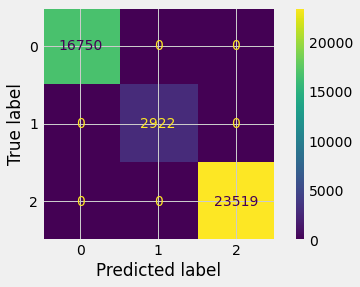

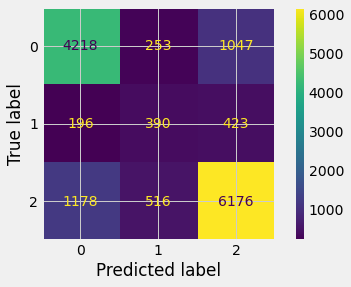

In [56]:
y_hat_train = pipe_dtree.predict(X_train)
y_hat_test = pipe_dtree.predict(X_test)

print('Evaluation Metrics: Train Data\n')
print(classification_report(y_train,y_hat_train))
print('---------------------------------------------\n')
print('Evaluation Metrics: Test Data\n')
print(classification_report(y_test,y_hat_test))

plot_confusion_matrix(pipe_dtree,X_train,y_train)
plot_confusion_matrix(pipe_dtree,X_test,y_test)

### Logistic Regression

In [57]:
pipe_lr = ImbPipe([('trsfm',clmntr),
                   ('sm',SMOTE(random_state=42)),
                   ('lr',LogisticRegression(random_state=42))])#
pipe_lr.fit(X_train,y_train)

Pipeline(steps=[('trsfm',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['funder', 'installer',
                                                   'wpt_name', 'basin',
                                                   'subvillage', 'region',
                                                   'lga', 'ward', 'recorded_by',
                                                   'scheme_management',
                                                   'scheme_name',
                                                   'extraction_type',
                                                   'extraction_type_group',
                                                   'extraction_type_class',
                                                   'management',
                      

Evaluation Metrics: Train Data

              precision    recall  f1-score   support

           0       0.79      0.69      0.74     16750
           1       0.23      0.75      0.35      2922
           2       0.83      0.67      0.74     23519

    accuracy                           0.68     43191
   macro avg       0.62      0.70      0.61     43191
weighted avg       0.77      0.68      0.71     43191

---------------------------------------------

Evaluation Metrics: Test Data

              precision    recall  f1-score   support

           0       0.77      0.68      0.72      5518
           1       0.22      0.69      0.33      1009
           2       0.82      0.66      0.73      7870

    accuracy                           0.67     14397
   macro avg       0.60      0.68      0.59     14397
weighted avg       0.76      0.67      0.70     14397



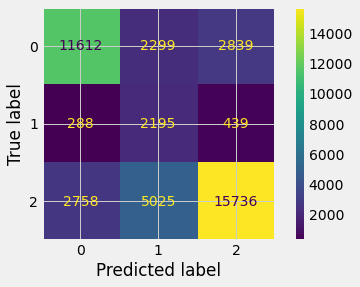

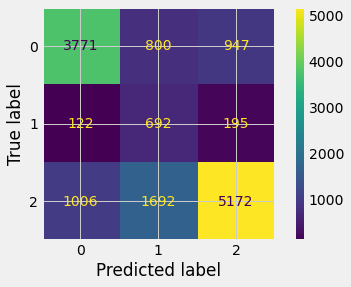

In [58]:
y_hat_train = pipe_lr.predict(X_train)
y_hat_test = pipe_lr.predict(X_test)

print('Evaluation Metrics: Train Data\n')
print(classification_report(y_train,y_hat_train))
print('---------------------------------------------\n')
print('Evaluation Metrics: Test Data\n')
print(classification_report(y_test,y_hat_test))

plot_confusion_matrix(pipe_lr,X_train,y_train)
plot_confusion_matrix(pipe_lr,X_test,y_test)

### KNN Classifier

In [59]:
pipe_knn = ImbPipe([('trsfm',clmntr),
                     ('sm',SMOTE(random_state=42,sampling_strategy='minority')),
                     ('lr',KNeighborsClassifier())])#
pipe_knn.fit(X_train,y_train)

Pipeline(steps=[('trsfm',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['funder', 'installer',
                                                   'wpt_name', 'basin',
                                                   'subvillage', 'region',
                                                   'lga', 'ward', 'recorded_by',
                                                   'scheme_management',
                                                   'scheme_name',
                                                   'extraction_type',
                                                   'extraction_type_group',
                                                   'extraction_type_class',
                                                   'management',
                      

Evaluation Metrics: Train Data

              precision    recall  f1-score   support

           0       0.89      0.79      0.84     16750
           1       0.40      0.90      0.56      2922
           2       0.89      0.82      0.85     23519

    accuracy                           0.81     43191
   macro avg       0.73      0.84      0.75     43191
weighted avg       0.86      0.81      0.83     43191

---------------------------------------------

Evaluation Metrics: Test Data

              precision    recall  f1-score   support

           0       0.81      0.71      0.76      5518
           1       0.25      0.61      0.36      1009
           2       0.82      0.75      0.79      7870

    accuracy                           0.72     14397
   macro avg       0.63      0.69      0.63     14397
weighted avg       0.78      0.72      0.74     14397



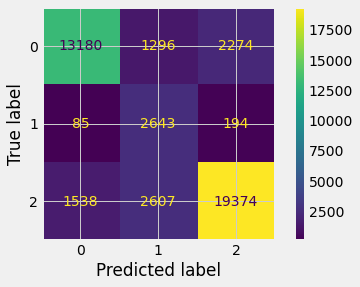

In [60]:
y_hat_train = pipe_knn.predict(X_train)
y_hat_test = pipe_knn.predict(X_test)

print('Evaluation Metrics: Train Data\n')
print(classification_report(y_train,y_hat_train))
print('---------------------------------------------\n')
print('Evaluation Metrics: Test Data\n')
print(classification_report(y_test,y_hat_test))

plot_confusion_matrix(pipe_knn,X_train,y_train)
plot_confusion_matrix(pipe_knn,X_test,y_test)

### Bagging Classifier

In [61]:
pipe_bag = ImbPipe([('trsfm',clmntr),
                     ('sm',SMOTE(random_state=42,sampling_strategy='minority')),
                     ('lr',BaggingClassifier(n_estimators=100,verbose=1,random_state=42))])#
pipe_bag.fit(X_train,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 11.6min finished


Pipeline(steps=[('trsfm',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['funder', 'installer',
                                                   'wpt_name', 'basin',
                                                   'subvillage', 'region',
                                                   'lga', 'ward', 'recorded_by',
                                                   'scheme_management',
                                                   'scheme_name',
                                                   'extraction_type',
                                                   'extraction_type_group',
                                                   'extraction_type_class',
                                                   'management',
                      

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   55.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.9s finished


Evaluation Metrics: Train Data

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16750
           1       1.00      1.00      1.00      2922
           2       1.00      1.00      1.00     23519

    accuracy                           1.00     43191
   macro avg       1.00      1.00      1.00     43191
weighted avg       1.00      1.00      1.00     43191

---------------------------------------------

Evaluation Metrics: Test Data

              precision    recall  f1-score   support

           0       0.81      0.77      0.79      5518
           1       0.39      0.42      0.40      1009
           2       0.82      0.83      0.83      7870

    accuracy                           0.78     14397
   macro avg       0.67      0.67      0.67     14397
weighted avg       0.78      0.78      0.78     14397



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   54.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.6s finished


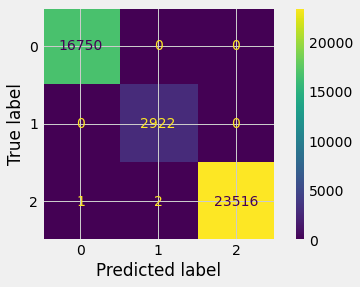

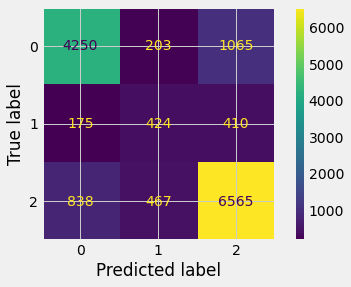

In [62]:
y_hat_train = pipe_bag.predict(X_train)
y_hat_test = pipe_bag.predict(X_test)

print('Evaluation Metrics: Train Data\n')
print(classification_report(y_train,y_hat_train))
print('---------------------------------------------\n')
print('Evaluation Metrics: Test Data\n')
print(classification_report(y_test,y_hat_test))

plot_confusion_matrix(pipe_bag,X_train,y_train)
plot_confusion_matrix(pipe_bag,X_test,y_test)

### Random Forest Classifier

In [63]:
pipe_rf = ImbPipe([('trsfm',clmntr),
                    ('sm', SMOTE(random_state = 42)),
                    ('rf',RandomForestClassifier())])
pipe_rf.fit(X_train,y_train)

Pipeline(steps=[('trsfm',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['funder', 'installer',
                                                   'wpt_name', 'basin',
                                                   'subvillage', 'region',
                                                   'lga', 'ward', 'recorded_by',
                                                   'scheme_management',
                                                   'scheme_name',
                                                   'extraction_type',
                                                   'extraction_type_group',
                                                   'extraction_type_class',
                                                   'management',
                      

Evaluation Metrics: Train Data

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16750
           1       1.00      1.00      1.00      2922
           2       1.00      1.00      1.00     23519

    accuracy                           1.00     43191
   macro avg       1.00      1.00      1.00     43191
weighted avg       1.00      1.00      1.00     43191

---------------------------------------------

Evaluation Metrics: Test Data

              precision    recall  f1-score   support

           0       0.80      0.79      0.79      5518
           1       0.41      0.41      0.41      1009
           2       0.82      0.83      0.83      7870

    accuracy                           0.78     14397
   macro avg       0.68      0.68      0.68     14397
weighted avg       0.78      0.78      0.78     14397



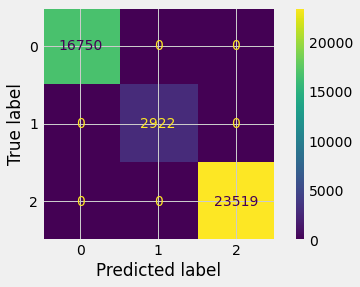

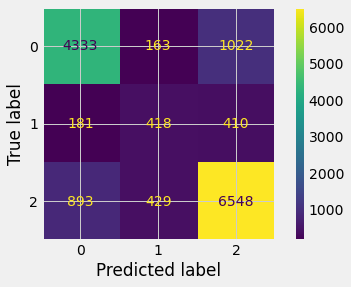

In [64]:
y_hat_train = pipe_rf.predict(X_train)
y_hat_test = pipe_rf.predict(X_test)

print('Evaluation Metrics: Train Data\n')
print(classification_report(y_train,y_hat_train))
print('---------------------------------------------\n')
print('Evaluation Metrics: Test Data\n')
print(classification_report(y_test,y_hat_test))

print(plot_confusion_matrix(pipe_rf,X_train,y_train))
print(plot_confusion_matrix(pipe_rf,X_test,y_test))

### Vanilla Model Results:
The results of all of the models are shown in the table below. It seems as the RandomForest model performed the best interms of accuracy, however did not perform as well in terms of the macro precision (KNN did better). We will go with the Random Forest as our baseline model as it is simpler to emplement and easier to optimize. Future work might include an ensemble of the Decision Tree and the KKN models.

|Model|Precision|Accuracy|
|:-----:|:-------:|:--------:|
|Random Forest|0.68|0.78|
|Bagging|0.67|0.78|
|KNN|0.69|0.77|
|Decision Tree|0.64|0.75|
|Logistic Regression|0.60|0.67|


# Optimizing The Random Forest Model

The model will be tuned using the Macro Precision score as an optimization parameter. This will prioritize the minimization of false positives from the predictions and will optimize the model for class imballance. The hyperparameters to be tuned are:

|Parameter|Paossible Values|
|:-------|:---------|
|Criterion| ```gini```, ```entropy```|
|Estimators|Number of Decision Trees (numeric)|
|Minimum Samples Split|Number of Sample minimum for splitting (numeric)|
|Minimum Samples Leaf|Number of Samples minimum to end splitting (numeric)|
|Max Features|The maximum features used in each estimator (numeric)|



### First Iteration: Criterion, N estimators, Minimum Samples, Split

In [66]:
param_grid = {
    'rf__n_estimators': [200, 300],
    'rf__criterion': ['gini'],
    'rf__min_samples_split': [4, 6],
    #'rf__min_samples_leaf': [1, 3],
    #'rf__max_features': ['auto', 'sqrt', 'log2']
}

search = GridSearchCV(pipe_rf, param_grid, scoring = 'precision_macro', n_jobs=-1)
search.fit(X_train, y_train)

print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.680):
{'rf__criterion': 'gini', 'rf__min_samples_split': 6, 'rf__n_estimators': 300}


Testing the model with the new parameters.

In [67]:
pipe_rf2 = ImbPipe([('trsfm',clmntr),
                    ('sm', SMOTE(random_state = 42)),
                    ('rf',RandomForestClassifier(criterion = 'gini', min_samples_split = 6, n_estimators = 200))])
pipe_rf2.fit(X_train,y_train)

Pipeline(steps=[('trsfm',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['funder', 'installer',
                                                   'wpt_name', 'basin',
                                                   'subvillage', 'region',
                                                   'lga', 'ward', 'recorded_by',
                                                   'scheme_management',
                                                   'scheme_name',
                                                   'extraction_type',
                                                   'extraction_type_group',
                                                   'extraction_type_class',
                                                   'management',
                      

Evaluation Metrics: Train Data

              precision    recall  f1-score   support

           0       0.96      0.92      0.94     16750
           1       0.85      0.87      0.86      2922
           2       0.94      0.96      0.95     23519

    accuracy                           0.94     43191
   macro avg       0.91      0.92      0.92     43191
weighted avg       0.94      0.94      0.94     43191

---------------------------------------------

Evaluation Metrics: Test Data

              precision    recall  f1-score   support

           0       0.82      0.78      0.80      5518
           1       0.42      0.41      0.41      1009
           2       0.82      0.85      0.83      7870

    accuracy                           0.79     14397
   macro avg       0.68      0.68      0.68     14397
weighted avg       0.79      0.79      0.79     14397



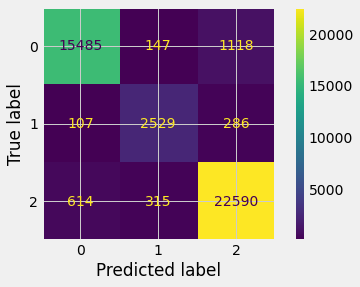

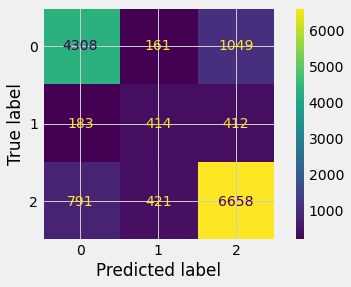

In [68]:
y_hat_train = pipe_rf2.predict(X_train)
y_hat_test = pipe_rf2.predict(X_test)

print('Evaluation Metrics: Train Data\n')
print(classification_report(y_train,y_hat_train))
print('---------------------------------------------\n')
print('Evaluation Metrics: Test Data\n')
print(classification_report(y_test,y_hat_test))

print(plot_confusion_matrix(pipe_rf2,X_train,y_train))
print(plot_confusion_matrix(pipe_rf2,X_test,y_test))

### Second Iteration: Max Features
- Other hyperparameters were held constant to cut computation time.
- This iteration will be used as the final model

In [69]:
param_grid = {
    'rf__n_estimators': [400],
    'rf__criterion': ['gini'],
    'rf__min_samples_split': [6],
    'rf__min_samples_leaf': [1],
    'rf__max_features': ['auto', 'sqrt', 'log2'],
}

search = GridSearchCV(pipe_rf, param_grid, scoring = 'precision_macro', n_jobs=-1)
search.fit(X_train, y_train)

print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.680):
{'rf__criterion': 'gini', 'rf__max_features': 'auto', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 6, 'rf__n_estimators': 400}


Testing the model with the new parameters.

In [363]:
pipe_rf = ImbPipe([('trsfm',clmntr),
                    ('sm', SMOTE(random_state = 42, sampling_strategy = 'minority')),
                    ('rf',RandomForestClassifier(
                        criterion = 'gini', min_samples_split = 6, n_estimators = 400, min_samples_leaf= 1, max_features = 'auto'
                    ))])
pipe_rf.fit(X_train,y_train)

Pipeline(steps=[('trsfm',
                 ColumnTransformer(transformers=[('ohe_strat',
                                                  Pipeline(steps=[('si_cat',
                                                                   SimpleImputer(fill_value='other',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['funder', 'installer',
                                                   'wpt_name', 'basin',
                                                   'subvillage', 'region',
                                                   'lga', 'ward',
                                                   'public_meet

Evaluation Metrics: Train Data

              precision    recall  f1-score   support

           0       0.96      0.91      0.93     17146
           1       0.84      0.86      0.85      3243
           2       0.93      0.96      0.95     24161

    accuracy                           0.94     44550
   macro avg       0.91      0.91      0.91     44550
weighted avg       0.94      0.94      0.94     44550

---------------------------------------------

Evaluation Metrics: Test Data

              precision    recall  f1-score   support

           0       0.84      0.75      0.79      5678
           1       0.42      0.43      0.43      1074
           2       0.81      0.86      0.83      8098

    accuracy                           0.79     14850
   macro avg       0.69      0.68      0.68     14850
weighted avg       0.79      0.79      0.79     14850



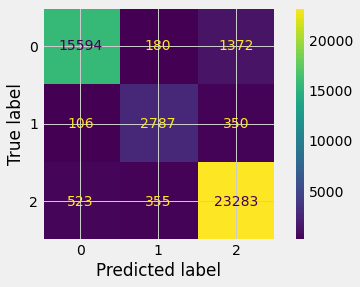

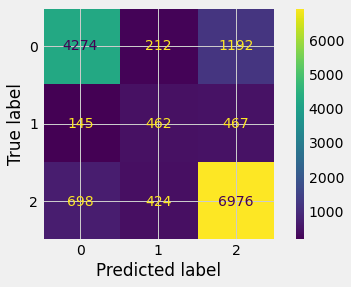

In [364]:
y_hat_train = pipe_rf.predict(X_train)
y_hat_test = pipe_rf.predict(X_test)

print('Evaluation Metrics: Train Data\n')
print(classification_report(y_train,y_hat_train))
print('---------------------------------------------\n')
print('Evaluation Metrics: Test Data\n')
print(classification_report(y_test,y_hat_test))

print(plot_confusion_matrix(pipe_rf,X_train,y_train))
print(plot_confusion_matrix(pipe_rf,X_test,y_test))

### Optimized Model Results

The accuracy and precision scores for the baseline, intermediate, and optimal model can be found in the table below. The optimized  model performed slightly better than our base model and enjoyed a 1% increase in macro precision and accuracy.

|Model| Precision| Accuracy|
|:-----:|:-------:|:--------:|
|Baseline| 0.68| 0.78|
|1st Iteration| 0.68| 0.79|
|Optimized| 0.69| 0.79|


### Key Features for Prediction
- Bases off of out optimized model, we found some key features that are important for predicting the water point function. The top 20 features can be found in the chart below.

Text(0, 0.5, 'Features')

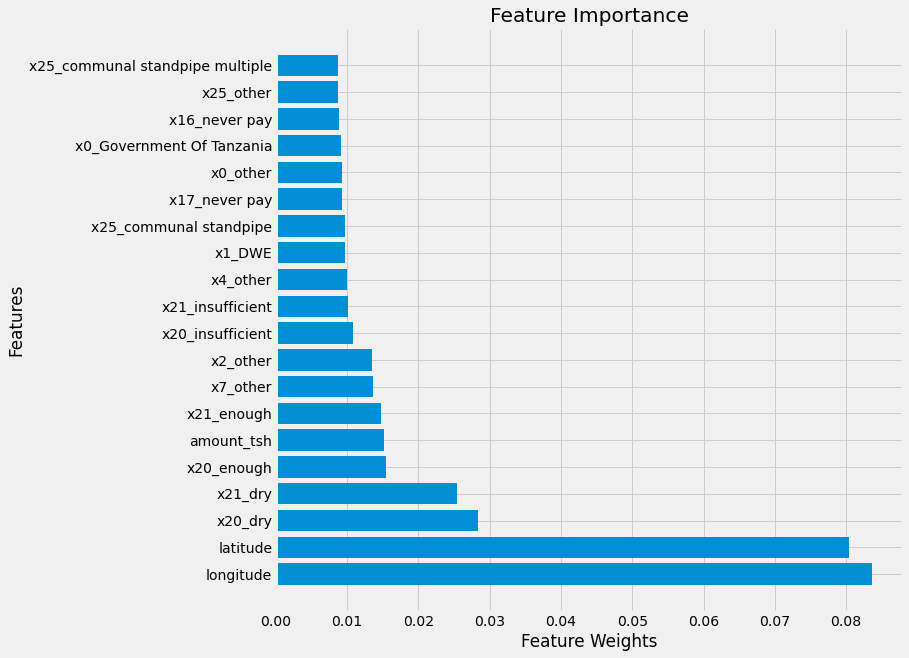

In [72]:
# Extracting all of the feature names from the final model
feature_names = list(pipe_rf.named_steps['trsfm'].transformers_[0][1].get_feature_names())
feature_names = feature_names + pipe_rf.named_steps['trsfm'].transformers_[1][2]

# Creating a dictionary witht the features and their importance values
feature_dict = dict(zip(feature_names,pipe_rf.steps[2][1].feature_importances_))
feature_dict_sorted = {k: v for k, v in sorted(feature_dict.items(), key=lambda item: item[1], reverse = True)}

# splitting the features and their values and taking the top 20 features
names = list(feature_dict_sorted.keys())[:20]
vals = list(feature_dict_sorted.values())[:20]

# Plotting the feature importances
fig, ax = plt.subplots(figsize = (10,10))
plt.barh(names, vals)
plt.title('Feature Importance')
ax.set_xlabel('Feature Weights')
ax.set_ylabel('Features')

## Final Model Test Predictions

In [384]:
pipe_rf = ImbPipe([('trsfm',clmntr),
                    ('sm', SMOTE(random_state = 42, sampling_strategy = 'minority')),
                    ('rf',RandomForestClassifier(
                        criterion = 'gini', min_samples_split = 6, n_estimators = 400, min_samples_leaf= 1, max_features = 'auto'
                    ))])
pipe_rf.fit(X_train,y_train)

Pipeline(steps=[('trsfm',
                 ColumnTransformer(transformers=[('ohe_strat',
                                                  Pipeline(steps=[('si_cat',
                                                                   SimpleImputer(fill_value='other',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['funder', 'installer',
                                                   'wpt_name', 'basin',
                                                   'subvillage', 'region',
                                                   'lga', 'ward',
                                                   'public_meet

Evaluation Metrics: Train Data

              precision    recall  f1-score   support

           0       0.96      0.91      0.94     17146
           1       0.84      0.86      0.85      3243
           2       0.93      0.96      0.95     24161

    accuracy                           0.94     44550
   macro avg       0.91      0.91      0.91     44550
weighted avg       0.94      0.94      0.94     44550

---------------------------------------------

Evaluation Metrics: Test Data

              precision    recall  f1-score   support

           0       0.83      0.76      0.79      5678
           1       0.42      0.43      0.43      1074
           2       0.81      0.86      0.83      8098

    accuracy                           0.79     14850
   macro avg       0.69      0.68      0.68     14850
weighted avg       0.79      0.79      0.79     14850



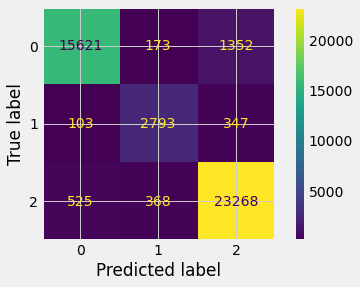

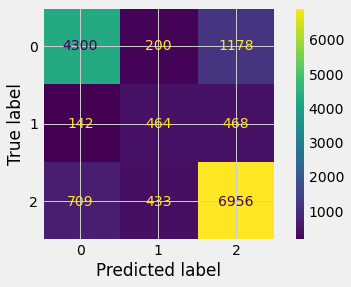

In [385]:
y_hat_train = pipe_rf.predict(X_train)
y_hat_test = pipe_rf.predict(X_test)

print('Evaluation Metrics: Train Data\n')
print(classification_report(y_train,y_hat_train))
print('---------------------------------------------\n')
print('Evaluation Metrics: Test Data\n')
print(classification_report(y_test,y_hat_test))

print(plot_confusion_matrix(pipe_rf,X_train,y_train))
print(plot_confusion_matrix(pipe_rf,X_test,y_test))

### Predictions from our model on the test data set to enter into the competition.

In [178]:
y_hat_test = pipe_rf.predict(test)

# Conclusions

**1. EDA** From the preliminary exploritory data analysis we found that the conition of the water well depends heavily on the type of water well, the amount of water being pulled from the point, the quality of water that it serves and the location/surrounding population of the water point

**2. Model** We found that the optimal model to give the best predictions was a Random Forest model which gave a 79% accuracy rate and a 69% precision rate meaning that this model will accurately predict the water point condition 79 times out of 100 and the model was optimized to limit the amouint of false positives or the possibility of predicting a well as functional when in reality it is not.

**3. Best Features** The features importances shows that the most importtant features in modeling and predicting the condition of a water point are the geographic location, the water point type, and the water quility at the point. This aligns with the exploratory data analysis done in the preceding section.

# Next Steps

Further analysis can be done to better predict the condition of a water point. The following are some suggestions for future iterations:

**1. Better Data** A large portion of the data were missing location, population, water yeild, and construction year. As is is likely that the condition of the pump would heavily rely on the age, amount of usage, and location of the water point, the lack in data should be addressed before more iterations can be made.

**2. New Data** Information such as the date of last repair, the failure mode if non functional, average climate information, and frequency of maintenance could be very influential in predicting the condition of the water point and could lead to a time sequenced prediction model.

**3. Time Sequence** It would be most interesting and perhaps most important to be able to pedict when a water point would need maintenance and the frequency of mainteneance required for a water point. Future iterations should be focussed on these kinds of predictions as they will be influential in defining maintenance routines.

